In [1]:
from transformers import (GPT2LMHeadModel, GPT2TokenizerFast,
                          BertForMaskedLM, BertTokenizerFast,
                          DistilBertForMaskedLM, DistilBertTokenizerFast,
                          RobertaForMaskedLM, RobertaTokenizerFast,
                          BlenderbotForCausalLM, BlenderbotTokenizer,
                          BigBirdForMaskedLM, BigBirdTokenizer,
                          ElectraForMaskedLM, ElectraTokenizerFast)
from multiprocessing import Pool
import pandas as pd
import glob
from itertools import product
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from lmeval.datasets import NarrativesDataset
from lmeval.engine import StridingMLM, StridingForwardLM

### Initialize list of models and parameters

In [3]:
transcripts = glob.glob('inputs/narratives/gentle/*/transcript*')
aligned = glob.glob('inputs/narratives/gentle/*/align.csv')
dataset_files = transcripts + aligned

In [4]:
model_classes = [GPT2LMHeadModel,
                 BertForMaskedLM,
                 DistilBertForMaskedLM, 
                 RobertaForMaskedLM, 
                 BlenderbotForCausalLM, 
                 BigBirdForMaskedLM,
                 ElectraForMaskedLM]
model_ids = ['gpt2', 
             'bert-base-uncased', 'distilbert-base-uncased',
             'roberta-base', 'facebook/blenderbot-400M-distill', 
             'google/bigbird-roberta-base', 
    'google/electra-base-discriminator']
tokenizer_classes = [GPT2TokenizerFast,
                     BertTokenizerFast,
                     DistilBertTokenizerFast,
                     RobertaTokenizerFast,
                     BlenderbotTokenizer,
                     BigBirdTokenizer,
                     ElectraTokenizerFast]
model_parameters = list(zip(model_classes, model_ids, tokenizer_classes))

In [5]:
ctx_lengths = [5, 10, 15, 20]

Create all combinations of files, model_parameters, and context lengths

In [6]:
parameters = list(product(dataset_files, 
                          model_parameters, 
                          ctx_lengths))
parameters = [(i[0], *i[1], i[2]) for i in parameters]

### Define validation function + utils

In [7]:
def _make_dataset_id(datafile):
    ds_name_splits = datafile.split('/')
    narrative = ds_name_splits[3]
    ds_type = ds_name_splits[-1].split('.')[0]
    ds_id = '_'.join([narrative, ds_type])
    return ds_id

In [8]:
def _validate(datafile, model_class, model_id, tokenizer_class, ctx_length):
    tokenizer = tokenizer_class.from_pretrained(model_id)
    model = model_class.from_pretrained(model_id)
    dataset_name = _make_dataset_id(datafile)
    data = NarrativesDataset(datafile, dataset_name)
    data.text = data.text[:100]
    if any([b in model_id for b in ['bert','electra',
                                    'bigbird']]):
        engine = StridingMLM(context_length=ctx_length)
    else:
        engine = StridingForwardLM(context_length=ctx_length)
    result = engine.run(data, tokenizer, model, model_id)
    return result

### Run in parallel

In [ ]:
for p in parameters:
    _validate(*p)

In [ ]:
pool = Pool(2)

In [61]:
results = pool.starmap(_validate, parameters)
pool.close()

### Save outputs

In [ ]:
for idx, df in enumerate(results):
    if idx == 0:
        r_all = df
    else:
        r_all = pd.concat([r_all, df], ignore_index=True)
r_all.to_csv('outs/validation_0909.txt', sep='\t')

## Read in data and plot

In [5]:
logs = glob.glob('outputs/*/*')

In [9]:
for l in logs:
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if l == logs[0]:
        all_logs = ldf
    else:
        all_logs = pd.concat([all_logs, 
                              ldf], ignore_index=True)

In [75]:
import numpy as np
all_logs['is_true'] = (all_logs['target'] == all_logs['top_predicted']).astype(int)
all_logs['surprisal'] = -np.log(all_logs['prob_true'])

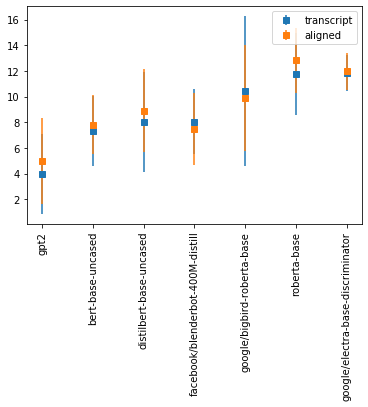

In [100]:
log_mean = all_logs.groupby(['model', 'context_size', 'type']).loss.agg(['mean', 'std']).reset_index()
log_mean.columns = ['model', 'context_size', 'type', 'mean_loss', 'std_loss']
log_mean = log_mean.sort_values(by='mean_loss')
#plt.subplots(figsize=(35,5))
for t in log_mean.type.unique():
    plt.errorbar(data=log_mean[(log_mean['context_size']==15) & (log_mean['type']==t)], 
                 x='model', 
                 y='mean_loss', 
                 yerr='std_loss', label=t, ls='none', marker='s')
    plt.legend()
    plt.xticks(rotation=90)
    #for a in f.axes.flat:
    #    _ = a.set_xticklabels(a.get_xticklabels(), rotation=90)
plt.show()

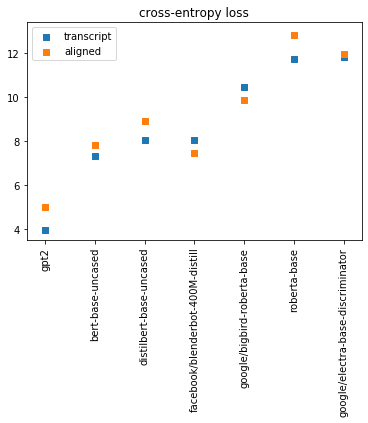

In [113]:
log_mean = all_logs.groupby(['model', 'context_size', 'type']).loss.mean().reset_index()
log_mean = log_mean.sort_values(by='loss')
for t in log_mean.type.unique():
    plt.scatter(data=log_mean[(log_mean['context_size']==15) & (log_mean['type']==t)], 
                 x='model', 
                 y='loss', 
                 label=t, marker='s')
    plt.legend()
    plt.xticks(rotation=90)
plt.title('cross-entropy loss')
plt.show()

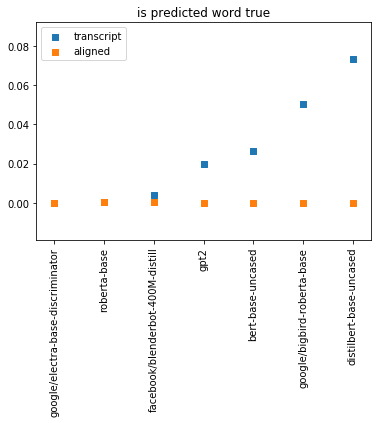

In [111]:
log_mean = all_logs.groupby(['model', 'context_size', 'type']).is_true.agg(['mean', 'std']).reset_index()
log_mean.columns = ['model', 'context_size', 'type', 'mean_loss', 'std_loss']
log_mean = log_mean.sort_values(by='mean_loss')
for t in log_mean.type.unique():
    plt.scatter(data=log_mean[(log_mean['context_size']==15) & (log_mean['type']==t)], 
                 x='model', 
                 y='mean_loss', 
                 label=t, marker='s')
    plt.legend()
    plt.xticks(rotation=90)
plt.title('is predicted word true')
plt.show()

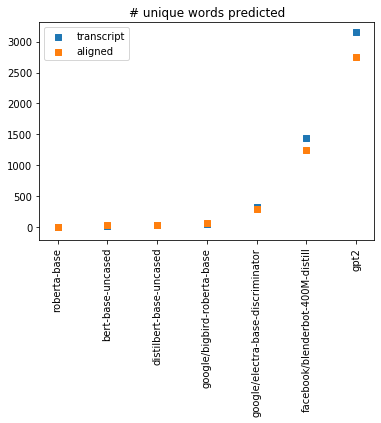

In [112]:
log_mean =  all_logs.groupby(['type', 'model', 'context_size']).top_predicted.nunique().reset_index()
log_mean = log_mean.sort_values(by='top_predicted')
for t in log_mean.type.unique():
    plt.scatter(data=log_mean[(log_mean['context_size']==15) & (log_mean['type']==t)], 
                 x='model', 
                 y='top_predicted', 
                 label=t, 
                 marker='s')
    plt.legend()
    plt.xticks(rotation=90)
plt.title('# unique words predicted')
plt.show()

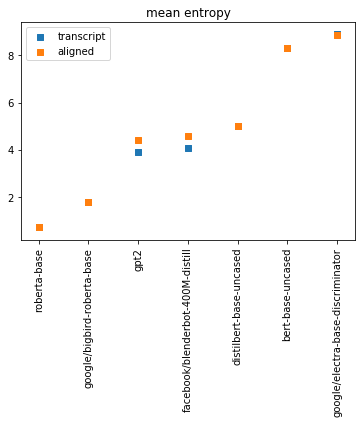

In [115]:
log_mean =  all_logs.groupby(['type', 'model', 'context_size']).entropy.mean().reset_index()
log_mean = log_mean.sort_values(by='entropy')
for t in log_mean.type.unique():
    plt.scatter(data=log_mean[(log_mean['context_size']==15) & (log_mean['type']==t)], 
                 x='model', 
                 y='entropy', 
                 label=t, 
                 marker='s')
    plt.legend()
    plt.xticks(rotation=90)
plt.title('mean entropy')
plt.show()

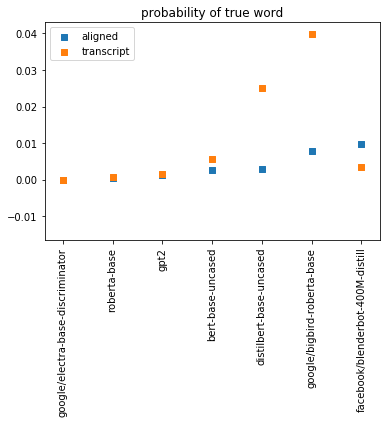

In [118]:
log_mean =  all_logs.groupby(['type', 'model', 'context_size']).prob_true.mean().reset_index()
log_mean = log_mean.sort_values(by='prob_true')
for t in log_mean.type.unique():
    plt.scatter(data=log_mean[(log_mean['context_size']==15) & (log_mean['type']==t)], 
                 x='model', 
                 y='prob_true', 
                 label=t, 
                 marker='s')
    plt.legend()
    plt.xticks(rotation=90)
plt.title('probability of true word')
plt.show()

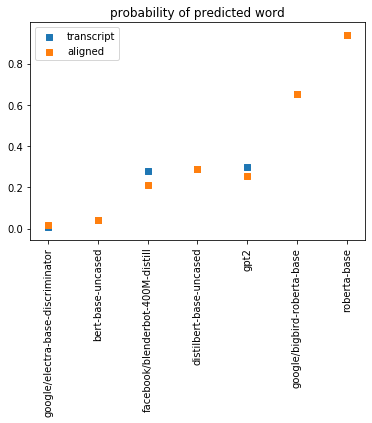

In [119]:
log_mean =  all_logs.groupby(['type', 'model', 'context_size']).prob_predicted.mean().reset_index()
log_mean = log_mean.sort_values(by='prob_predicted')
for t in log_mean.type.unique():
    plt.scatter(data=log_mean[(log_mean['context_size']==15) & (log_mean['type']==t)], 
                 x='model', 
                 y='prob_predicted', 
                 label=t, 
                 marker='s')
    plt.legend()
    plt.xticks(rotation=90)
plt.title('probability of predicted word')
plt.show()

In [ ]:
# See to dos in engine